In [4]:
# Loading and parsing data

# PLOT - parse data + std-dev
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import ticker
from scipy import stats

sns.set(rc={'figure.figsize':(8,4)})
sns.set_style("whitegrid")

def p50_estimator(x):
    return np.percentile(x, 50)
def p95_estimator(x):
    return np.percentile(x, 95)
def p99_estimator(x):
    return np.percentile(x, 99)

# read hot RDMA
dfs = []
for size in [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096]:
    data = pd.read_csv(os.path.join('hot_libfabric', f'{size}.csv'), skiprows=50, usecols=[1], names=["time"])
    data['size'] = size
    data['time'] *= 2/1000
    dfs.append(data)
data_perftest = pd.concat(dfs, axis=0)
data_perftest['type'] = 'perftest'

# read warm RDMA
dfs = []
for size in [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096]:
    data = pd.read_csv(os.path.join('warm_libfabric', f'{size}.csv'), skiprows=50, usecols=[1], names=["time"])
    data['size'] = size
    data['time'] *= 2/1000
    dfs.append(data)
data_perftest_warm = pd.concat(dfs, axis=0)
data_perftest_warm['type'] = 'perftest_warm'

# read serverless hot
dfs = []
for size in [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096]:
    data = pd.read_csv(os.path.join('hot', f'{size}.csv'))
    data.set_index('id', drop=True, inplace=True)
    data['size'] = size
    data['time'] /= 1000.0
    dfs.append(data)
data_serverless = pd.concat(dfs, axis=0)
data_serverless['type'] = 'serverless_hot'

# read serverless warm
dfs = []
for size in [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096]:
    data = pd.read_csv(os.path.join('warm', f'{size}.csv'))
    data.set_index('id', drop=True, inplace=True)
    data['size'] = size
    data['time'] /= 1000.0
    dfs.append(data)
data_serverless_warm = pd.concat(dfs, axis=0)
data_serverless_warm['type'] = 'serverless_warm'

for size in [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096]:
    data_slice = data_serverless.loc[data_serverless['size'] == size, 'time']
    print(f'Serverless hot {size}, p50 {np.percentile(data_slice,50)}, p95 {np.percentile(data_slice,95)}, p99 {np.percentile(data_slice,99)}')
print('-------------------')
for size in [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096]:
    data_slice = data_serverless_warm.loc[data_serverless_warm['size'] == size,'time']
    print(f'Serverless warm {size}, p50 {np.percentile(data_slice,50)}, p95 {np.percentile(data_slice,95)}, p99 {np.percentile(data_slice,99)}')
print('-------------------')
for size in [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096]:
    data_slice = data_perftest.loc[data_perftest['size'] == size, 'time']
    print(f'RDMA hot {size}, p50 {np.percentile(data_slice,50)}, p95 {np.percentile(data_slice,95)}, p99 {np.percentile(data_slice,99)}')
print('-------------------')
for size in [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096]:
    data_slice = data_perftest_warm.loc[data_perftest_warm['size'] == size, 'time']
    print(f'RDMA warm {size}, p50 {np.percentile(data_slice,50)}, p95 {np.percentile(data_slice,95)}, p99 {np.percentile(data_slice,99)}')
print('-------------------')

data = pd.concat([data_perftest, data_perftest_warm, data_serverless, data_serverless_warm], axis=0, ignore_index=True)
faas_median = data[data['type'] == 'serverless_hot'].groupby(['size']).median()
faas_median2 = data[data['type'] == 'serverless_warm'].groupby(['size']).median()
rdma_median = data[data['type'] == 'perftest'].groupby(['size']).median()
rdma_median2 = data[data['type'] == 'perftest_warm'].groupby(['size']).median()
print('RDMA hot median', rdma_median)
diff=(faas_median-rdma_median)['time'].dropna()
print('Difference between FaaS Hot and RDMA hot, ', diff)
print('Avg Difference between FaaS Hot and RDMA, ', diff.mean())
diff2=(faas_median2-rdma_median2)['time'].dropna()
print('Difference between FaaS Warm and RDMA warm, ', diff2)
print('Avg Difference between FaaS Warm and RDMA warm, ', diff2.mean())
print('-------------------')

Serverless hot 1, p50 8.086, p95 9.97, p99 13.801680000000037
Serverless hot 2, p50 8.044, p95 9.76105, p99 22.09980000000004
Serverless hot 4, p50 8.016, p95 9.597099999999998, p99 22.581170000000025
Serverless hot 8, p50 8.076, p95 9.6761, p99 23.530110000000004
Serverless hot 16, p50 8.0655, p95 9.571, p99 22.33404
Serverless hot 32, p50 8.055, p95 9.56305, p99 13.060010000000002
Serverless hot 64, p50 8.132, p95 9.787149999999999, p99 22.769970000000132
Serverless hot 128, p50 8.111, p95 9.298000000000002, p99 19.393540000000208
Serverless hot 256, p50 8.04, p95 9.56005, p99 12.817140000000046
Serverless hot 512, p50 8.118, p95 10.116149999999998, p99 12.870680000000014
Serverless hot 1024, p50 8.296, p95 9.479099999999999, p99 20.674510000000012
Serverless hot 2048, p50 8.958, p95 10.192, p99 22.53460000000001
Serverless hot 4096, p50 11.214, p95 12.508, p99 23.24377000000006
-------------------
Serverless warm 1, p50 70.921, p95 116.69164999999995, p99 13547.751420000002
Serverle

/home/altair/Repos/api_venv/lib/python3.7/site-packages/ipykernel_launcher.py:41: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.


8


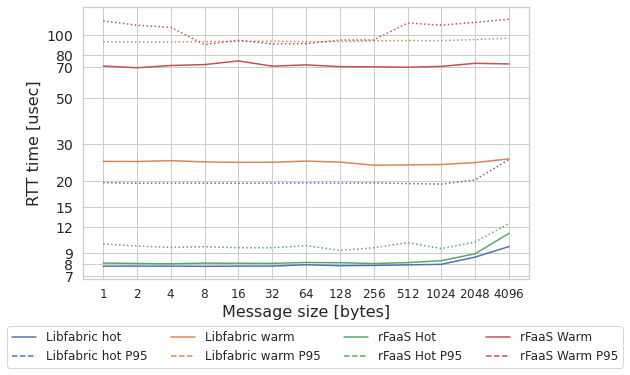

In [31]:
# PLOT - non-parametric CI, but smaller.

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import ticker
from scipy import stats
import math

sns.set(rc={'figure.figsize':(8,5)})
sns.set_style("whitegrid")

def p50_estimator(x):
    return np.percentile(x, 50)
def p95_estimator(x):
    return np.percentile(x, 95)
def p99_estimator(x):
    return np.percentile(x, 99)


ax = plt.gca()

plt = sns.lineplot(x="size", y="time", hue='type', ci=None, estimator=p50_estimator, data=data, ax=ax)
#sns.lineplot(x="size", y="Mean Latency Microseconds",data=ethernet_data, color='red', ax=ax)
#legend_ethernet.append(ax.lines[-1])

sns.lineplot(x="size", y="time", hue='type', ci=None, estimator=p95_estimator, data=data, ax=ax)
# I don't know why but matplotlib has 4 lines here: 2 are plotted, 2 are used as legend labels
#ax.lines[-4].set_linestyle("dotted")
ax.lines[-5].set_linestyle("dotted")
ax.lines[-6].set_linestyle("dotted")
ax.lines[-7].set_linestyle("dotted")
ax.lines[-8].set_linestyle("dotted")

#sns.lineplot(x="size", y="99th Percentile Latency Microseconds", data=ethernet_data, color='red', ax=ax)
#ax.lines[-1].set_linestyle("dotted")
#legend_ethernet.append(ax.lines[-1])

ax.set_xscale("log", basex=2)
ax.set_yscale("log")
ax.set_xticks([1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096])
ax.xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
ax.set_yticks([7, 8, 9, 12, 15, 20, 30, 50, 70, 80, 100])
ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
ax.set_xlabel('Message size [bytes]',fontsize=16)
ax.set_ylabel('RTT time [usec]',fontsize=16)

ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=14)

handles, labels = ax.get_legend_handles_labels()
# I don't know why but matplotlib doesn't import the style for some lines
handles[4].set_linestyle("--")
handles[5].set_linestyle("--")
handles[6].set_linestyle("--")
handles[7].set_linestyle("--")
print(len(handles))

# explain in caption what doted lines are
labels = ["Libfabric hot", "Libfabric warm", "rFaaS Hot", "rFaaS Warm", "Libfabric hot P95", "Libfabric warm P95", "rFaaS Hot P95", "rFaaS Warm P95"]

labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
ax.legend(handles, labels, ncol=4, bbox_to_anchor=(0.52, -0.35), loc='lower center', fontsize=12)


# sizes = np.array([1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096])
# low = np.zeros(sizes.shape)
# high = np.zeros(sizes.shape)

# col_palette = sns.color_palette()
# #full_data = pd.concat([data, ethernet_data], axis=0)
# for idx, data_type in enumerate(['perftest', 'serverless_hot', 'serverless_warm']):

#     i = 0
#     data2 = data.loc[(data['type'] == data_type)]
#     for row, group in data2.groupby(['size']):
#         d = np.sort(group['time'])
#         n = len(d)
#         low_pos = int(math.floor( (n - 1.96*math.sqrt(n)) / 2))
#         high_pos = int(math.ceil(1 +  (n + 1.96*math.sqrt(n)) / 2))
#         print(f'{data_type}, {row}, Non-param 95, {d[low_pos]}, {d[int(n/2)]}, {d[high_pos]}')
#         low_pos = int(math.floor( (n - 2.456*math.sqrt(n)) / 2))
#         high_pos = int(math.ceil(1 +  (n + 2.456*math.sqrt(n)) / 2))
#         print(f'{data_type}, {row}, Non-param 99, {d[low_pos]}, {d[int(n/2)]}, {d[high_pos]}')
#         low[i] = d[low_pos]
#         high[i] = d[high_pos]
#         i += 1

#     indices = {
#         0:0,
#         1:3,
#         2:2
#     }
#     #low -= 0.5
#     #high += 0.5
#     plt.fill_between(sizes, low, high, alpha=.3, color=col_palette[indices[idx]])


# ax.annotate('Inlining effects', xy=(150, 4.5), xytext=(400, 4),fontsize=16,#fontweight='bold',
#             ha="left", va="center",
#             arrowprops=dict(facecolor='black', shrink=0.05),
#             )

# ax.annotate('rFaaS hot latency: 3.96 usec', xy=(1, 4), xytext=(1, 6),fontsize=16,#fontweight='bold',
#             ha="left", va="center",
#             arrowprops=dict(facecolor='black', shrink=0.05),
#             )

# ax.annotate('rFaaS warm latency: 8.2 usec', xy=(1, 8), xytext=(1, 11.5),fontsize=16,#fontweight='bold',
#             ha="left", va="center",
#             arrowprops=dict(facecolor='black', shrink=0.05),
#             )

plt.figure.savefig("plot_latency.pdf",bbox_inches='tight',pad_inches = 0, transparent=False)